In [1]:
import os
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

In [2]:
# Calculate Expected Pass Rate

In [3]:
# Set CONSTANTS
SEASONS = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
# SEASONS = [2016,2017,2018,2019,2020,2021]

In [4]:
# get play by play for season
def get_pbp():
    cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'qtr',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'vegas_wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam','posteam_score',
        'defteam','defteam_score',
        'posteam_timeouts_remaining',
        'defteam_timeouts_remaining',
        'half_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards']
    
    # import play-by-play data as DataFrame
    return nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)
    
df_pbp = get_pbp()    

In [15]:
def get_df(df_pbp=pd.DataFrame()):
    if df_pbp.empty:
        df_pbp=get_pbp()
        
    # create additional features
    df_pbp['score_diff'] = df_pbp.posteam_score - df_pbp.defteam_score
    df_pbp['home'] = np.select([df_pbp.posteam == df_pbp.home_team],[1], default=0) 
    # define era of play
    era_conditions = [df_pbp.season.isin([2006,2007,2008,2009,2010,2011,2013]),
                      df_pbp.season.isin([2014,2015,2016,2017]),
                      df_pbp.season >= 2018]
    era_choices = [2,3,4]
    # create column for variable reflecting era of play
    df_pbp['era'] = np.select(era_conditions, era_choices, default=np.NaN)
    # get nfl schedule of seasons for roof/field type
    df_schd = nfl.import_schedules(years=SEASONS)
    # merge roof/field type to play by play DataFrame on game_id
    df_pbp = df_pbp.merge(df_schd[['game_id','roof']], on=['game_id'])
    # conditions for DataFrame
    is_down = df_pbp['down'].isin([1,2,3,4])
    is_runpass = df_pbp['play_type'].isin(['run','pass'])
    # return play-by-play DataFrame with specified columns under specified conditions
    return df_pbp.loc[(is_runpass & is_down), ['play_type',
                                             'roof',
                                             'era',
                                             'score_diff',
                                             'home',
                                             'down',
                                             'ydstogo',
                                             'yardline_100',
                                             'game_half',
                                             'qtr',
                                             'half_seconds_remaining',
                                             'posteam_timeouts_remaining',
                                             'defteam_timeouts_remaining',
                                             'wp',
                                             'vegas_wp',]].dropna().copy()

df = get_df(df_pbp)

In [16]:
print(df.play_type.value_counts())
df.sample(25)

pass    304037
run     218253
Name: play_type, dtype: int64


,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,vegas_wp
729074,run,dome,4.0,7.0,0,1.0,10.0,67.0,Half2,4.0,81.0,2.0,3.0,0.988111,0.989565
429745,run,outdoors,3.0,14.0,1,1.0,10.0,59.0,Half1,2.0,799.0,3.0,2.0,0.918614,0.966913
555195,pass,dome,3.0,0.0,0,2.0,5.0,24.0,Half1,2.0,363.0,1.0,2.0,0.549814,0.584592
247076,pass,outdoors,2.0,-7.0,0,2.0,6.0,92.0,Half1,2.0,386.0,2.0,2.0,0.260192,0.139773
153269,pass,dome,2.0,-21.0,1,2.0,9.0,12.0,Half2,3.0,926.0,3.0,3.0,0.030713,0.008387
472102,pass,closed,3.0,-30.0,0,3.0,6.0,76.0,Half2,3.0,1041.0,3.0,3.0,0.000649,0.000184
358387,pass,outdoors,2.0,-8.0,1,3.0,13.0,54.0,Half2,4.0,116.0,1.0,3.0,0.049101,0.060123
791589,pass,outdoors,4.0,-7.0,0,2.0,10.0,75.0,Half1,1.0,1396.0,3.0,3.0,0.224825,0.079341
201085,pass,outdoors,2.0,5.0,1,3.0,8.0,62.0,Half1,2.0,561.0,3.0,3.0,0.729675,0.481934
720807,run,outdoors,4.0,-13.0,1,1.0,10.0,38.0,Half2,4.0,567.0,2.0,3.0,0.074405,0.050016


In [17]:
df.dtypes

play_type                      object
roof                           object
era                           float64
score_diff                    float32
home                            int64
down                          float32
ydstogo                       float32
yardline_100                  float32
game_half                      object
qtr                           float32
half_seconds_remaining        float32
posteam_timeouts_remaining    float32
defteam_timeouts_remaining    float32
wp                            float32
vegas_wp                      float32
dtype: object

In [18]:
cat_features = ['roof',
             'era',
             'home',
             'down',
             'qtr',
             'game_half']

cont_features = ['score_diff',
              'wp',
              'vegas_wp',
              'ydstogo',
              'yardline_100',
              'half_seconds_remaining',
              'posteam_timeouts_remaining',
              'defteam_timeouts_remaining']

In [34]:
ylabel_enc = LabelEncoder()
categorical_transformer = Pipeline(steps=[("one_hot", OneHotEncoder())])
continuous_transformer = Pipeline(steps=[])
preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, cat_features)], remainder='passthrough')

xgb_model = XGBClassifier(booster="gbtree",
                           objective="binary:logistic",
                           eval_metric = ["error","logloss"],
                           eta=0.015,
                           gamma=2,
                           subsample=0.8,
                           colsample_bytree = 0.8,
                           max_depth = 7,
                           min_child_weight = 0.9,
                           base_score = np.mean(y),
                          n_estimators=1121
                          )

In [35]:
X = get_df(df_pbp).drop("play_type", axis=1)
y = ylabel_enc.fit_transform(get_df(df_pbp).play_type)

In [36]:
xgb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),("model", xgb_model)]
)


In [37]:
xgb_pipeline.fit(X,y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['roof', 'era', 'home',
                                                   'down', 'qtr',
                                                   'game_half'])])),
                ('model',
                 XGBClassifier(base_score=0.41787704149035976, booster='gbtree',
                               callbacks=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=0.8,
                               early_stoppi...
                               feature_types=None, gamma=2, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.0149999997, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=7, max_leaves=0,
                               min_child_weight=0.9, missing=nan,
                               monotone_constraints='()', n_estimators=1121,
                               n_jobs=0, num_parallel_tree=1, predictor='auto', ...))])

In [38]:
pred_probas = xgb_pipeline.predict_proba(X)
preds = xgb_pipeline.predict(X)

In [39]:
len(preds)

522290

In [40]:
pred_probas

array([[0.43124628, 0.5687537 ],
       [0.4425074 , 0.5574926 ],
       [0.9206082 , 0.07939176],
       ...,
       [0.61045176, 0.38954824],
       [0.01953405, 0.98046595],
       [0.96974695, 0.03025304]], dtype=float32)

In [41]:
df["preds"] = np.abs(preds -1)
df["xp"] = pred_probas[:,0]
df

,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,vegas_wp,preds,xp,play_type_class,bin_pred_prob,situation
2,run,outdoors,2.0,0.0,0,1.0,10.0,67.0,Half1,1.0,1794.0,3.0,3.0,0.439629,0.329839,0,0.431246,0,0.45,1st & 10
3,run,outdoors,2.0,0.0,0,2.0,5.0,62.0,Half1,1.0,1758.0,3.0,3.0,0.441971,0.344370,0,0.442507,0,0.50,2nd down
4,pass,outdoors,2.0,0.0,0,3.0,6.0,63.0,Half1,1.0,1713.0,3.0,3.0,0.418461,0.339631,1,0.920608,1,0.80,3rd down
6,pass,outdoors,2.0,0.0,0,1.0,10.0,38.0,Half1,1.0,1671.0,3.0,3.0,0.530412,0.413574,0,0.411774,1,0.45,1st & 10
7,run,outdoors,2.0,0.0,0,2.0,5.0,33.0,Half1,1.0,1637.0,3.0,3.0,0.517820,0.397170,0,0.402464,0,0.50,2nd down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796997,run,outdoors,4.0,5.0,0,1.0,10.0,53.0,Half2,4.0,114.0,3.0,3.0,0.946630,0.908322,0,0.033640,0,0.20,1st & 10
796999,run,outdoors,4.0,5.0,0,2.0,9.0,52.0,Half2,4.0,109.0,3.0,2.0,0.952934,0.904982,0,0.118324,0,0.30,2nd down
797001,pass,outdoors,4.0,5.0,0,3.0,7.0,50.0,Half2,4.0,105.0,3.0,1.0,0.933351,0.896058,1,0.610452,1,0.70,3rd down
797002,run,outdoors,4.0,5.0,0,1.0,10.0,47.0,Half2,4.0,98.0,3.0,1.0,0.972037,0.941868,0,0.019534,0,0.15,1st & 10


In [42]:
df['play_type_class'] = np.select([df['play_type'] == 'pass', df['play_type'] == 'run'],[1,0], default=0)

df['bin_pred_prob'] = round(df['xp'] / 0.05) * 0.05

df['situation'] = np.select([((df.down == 1) & (df.ydstogo == 10)),
                             (df.down == 2),
                             (df.down == 3)],
                            ['1st & 10', '2nd down', '3rd down'], default = 'Other')
df_xp=(df.groupby(['situation', 'bin_pred_prob']).agg({'play_type_class':[('n_plays','count'),('n_complete', 'sum')]})
 .droplevel(level=0, axis=1)
 .reset_index()
 .assign(bin_actual_prob= lambda x: x.n_complete / x.n_plays)
)
df_xp

,situation,bin_pred_prob,n_plays,n_complete,bin_actual_prob
0,1st & 10,0.00,687,2,0.002911
1,1st & 10,0.05,2758,76,0.027556
2,1st & 10,0.10,2114,150,0.070956
3,1st & 10,0.15,2009,199,0.099054
4,1st & 10,0.20,2488,411,0.165193
...,...,...,...,...,...
79,Other,0.80,1050,882,0.840000
80,Other,0.85,1302,1162,0.892473
81,Other,0.90,1514,1414,0.933950
82,Other,0.95,2532,2458,0.970774


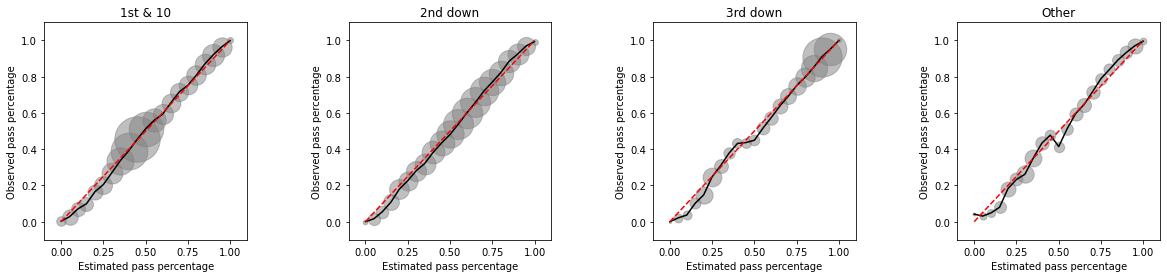

In [43]:

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = (0,1)
        low_y, high_y = (0,1)
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


fig, ax = plt.subplots(1,4, figsize=(20,4))
fig.subplots_adjust(wspace=0.5)
for idx, situation in enumerate(df_xp.situation.unique()):
    for row_idx, row in df_xp[df_xp.situation == situation].iterrows():
        ax[idx].scatter(x=row.bin_pred_prob, y=row.bin_actual_prob, s=2**np.log(row.n_plays), alpha=0.5,color='grey')
    ax[idx].plot('bin_pred_prob', 'bin_actual_prob', data=df_xp[df_xp.situation == situation], color='k')
    add_identity(ax[idx], color='r', ls='--')
    ax[idx].set_title(situation)
    ax[idx].set_xlim([-0.1,1.1])
    ax[idx].set_ylim([-0.1,1.1])
    ax[idx].set_xlabel('Estimated pass percentage')
    ax[idx].set_ylabel('Observed pass percentage')
    

plt.show()

In [44]:
# Calculate error between expected and observed

wm = lambda x: np.average(x, weights=df_xp.loc[x.index, "n_plays"])

df_xp['cal_diff'] = abs(df_xp.bin_pred_prob - df_xp.bin_actual_prob)
xp_cv_cal_error = df_xp.groupby('situation').agg(n_complete=('n_complete','sum'),weighted_cal_error=('cal_diff',wm))
round(np.average(xp_cv_cal_error.weighted_cal_error, weights=xp_cv_cal_error.n_complete),4)


0.014